이 자료는 **HW#03**을 위한 자료이다. 비어있는 코드를 완성한 후 ipynb 파일과 실행결과를 포함한 pdf파일을 LMS에 제출한다.

In [271]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import os, cv2, json

## Eigenfaces

NIA의 AI-Hub에서 제공하는 ['한국인 감정인식을 위한 복합 영상'](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=82) 데이터세트를 사용한다.


*   소개

   장면의 맥락 정보를 통한 감정 분석을 위한 얼굴 표정 이미지 데이터.

*   구축목적

   한국인의 얼굴 표정과 장소 맥락을 고려하여 인공지능이 사람의 감정을 이해할 수 있는 학습 모델 개발.

*   활용 분야

   감정분석을 통한 소비자의 만족도 측정, 감정기록을 통한 멘탈 헬스케어, 감정인식을 통한 감성 컴퓨팅(Affective Computing) 분야 등.





위의 링크에서 데이터를 다운로드 받은 후 여러분의 구글드라이브 특정 디렉토리 (예, `HW03`) 아래에 `'경북대 정순기 교수 컴퓨터 비전 수업자료'` 디렉토리 업로드한 후 아래의 셀을 실행한다.

In [244]:
# This cell mounts github to google drive
import os
from google.colab import drive

drive.mount('/content/gdrive')

# 아래의 디렉토리는 여러분의 실행환경에 맞게 수정이 필요하다.
%cd /content/gdrive/MyDrive/

if os.path.isdir("경북대 정순기 교수 컴퓨터 비전 수업자료") == True:
    %cd '경북대 정순기 교수 컴퓨터 비전 수업자료'
    print("Ready to do homework")
else:
    print("Not ready to do homework")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive
/content/gdrive/MyDrive/경북대 정순기 교수 컴퓨터 비전 수업자료
Ready to do homework


In [245]:
emotion = ['기쁨', '당황','분노','슬픔','중립']
json_data = []

본 자료는 Training과 Validation을 위한 분리된 디렉토리에 데이터가 저장되어 있고, 파일 이름이 다르기 때문에 `mode_label` 딕셔너리에 관련 내용을 저장해둔다. 이를 이용해서 `json_path()` 함수는 `emotion`과 `mode`를 통해 필요한 데이터의 메타데이터가 저장된 json 파일 경로를 리턴한다. `image_path()` 함수는 이미지 파일 경로를 리턴한다. 

In [246]:
mode_label = {'Mode' : ['Training', 'Validation'],
           'MODE' : ['TRAIN', 'VALID'],
           'mode' : ['training', 'validation']}

def json_path(emotion, mode):
    return '%s/[라벨]EMOIMG_%s_%s/img_emotion_%s_data(%s).json' % (
        mode_label['Mode'][mode], emotion, 
        mode_label['MODE'][mode], 
              mode_label['mode'][mode], emotion)

def image_path(emotion, mode, jpg_name):
    return os.path.join('%s/[원천]EMOIMG_%s_%s/' % (
        mode_label['Mode'][mode], emotion, 
        mode_label['MODE'][mode]) + jpg_name)

In [247]:
# Read json_data for Training and Validation
for m in range(2):
    for e in emotion:
        with open(json_path(e, m)) as json_file:
            json_ = json.load(json_file)
        for k in range(len(json_)):
            json_[k]['mode'] = mode_label['mode'][m]
            json_data.append(json_[k])

`json_data`는 json 데이터의 정보를 저장하는 list이다. 아래의 `json_data[0]`을 통해 첫번째 데이터의 내용에 어떠한 정보가 저장되어 있는지를 확인할 수 있다.

In [248]:
json_data[0]

{'filename': '0a3a21be68414f07a0e035671e8e3911c7376b4cfc6e100c8a1e240423676188_남_20_기쁨_공공시설&종교&의료시설_20201206192953-001-011.jpg',
 'gender': '남',
 'age': 20,
 'isProf': '전문인',
 'faceExp_uploader': '기쁨',
 'bg_uploader': '공공시설/종교/의료시설',
 'annot_A': {'boxes': {'maxX': 1903.9749,
   'maxY': 1289.9767999999997,
   'minX': 1217.2223,
   'minY': 446.40903000000003},
  'faceExp': '기쁨',
  'bg': '공공시설/종교/의료'},
 'annot_B': {'boxes': {'maxX': 1891.3776342943142,
   'maxY': 1289.9768000000008,
   'minX': 1255.3985130741073,
   'minY': 446.40903000000037},
  'faceExp': '기쁨',
  'bg': '공공시설/종교/의료'},
 'annot_C': {'boxes': {'maxX': 1903.9749,
   'maxY': 1289.9768,
   'minX': 1217.2223,
   'minY': 446.40903},
  'faceExp': '기쁨',
  'bg': '공공시설/종교/의료'},
 'mode': 'training'}

`faces`는 "한국인 감정인식을 위한 복합 영상"의 축소 데이터를 읽어서 딕셔너리로 저장합니다. 각 항목은 list로 저장되며 다음의 내용을 포함하고 있다.


* `'images'`: 원 컬러 영상 (전체 소비되는 메모리 용량을 줄이기 위하여 가로,세로 1/4로 축소하여 저장)
* `'face'`: 원 컬러 영상에서 사전에 라벨링된 bounding box으로 crop한 후 향후 동일한 크기로 처리하기 위하여 (가로, 세로) = (47, 62)로 크기변환(resize)하여 저장
* `'bbox'`: 원 영상에서 얼굴 영역을 포함하는 bounding box 정보이며, `'minX'`, `'minY'`, `'maxX'`, `'maxY'`에 대한 값을 저장하고 있는 딕셔너리. (원 json 파일에는 `'annot_A/B/C'`의 세 개의 bounding box 정보가 있으나 본 과제에서는 `'annot_A'`를 사용함  
* `'data'`: `'face'`의 2차원 데이터를 1차원 벡터로 변환((flatten)하여 저장 
* `'emotion'`: 각 영상의 표정 레이블 정보. `'기쁨'`, `'당황`',`'분노'`,`'슬픔'`,`'중립'` 중의 하나의 값을 저장
* `'mode'`: 영상의 용도. `'training'` 혹은 `'validation'`
* `'gender'`, `'age'`, `'job'`, `'bg'` 등의 정보는 본 과제에서 사용하지 않으므로 저장하지 않음)



In [249]:
# Initialization of faces dictionary
faces = { 'images': [], 'bbox':[], 'face' : [], 'data': [], 'emotion': [], 'mode':[] }

`read_image` 함수는 주어진 경로의 영상 파일을 배열로 읽고, 이를 cv2 패키지의 함수를 사용하여 컬러 영상을 저장한다.

`extract_face` 함수는 faces의 'images'에 마지막으로 저장되어 있는 컬러 영상을 흑백영상으로 변환한 후 주어진 `bbox를` 사용하여 crop하여 (47, 62) 크기의 영상으로 변환하여 `faces['face']`에 추가하고, 이를 1차원 벡터로 변환하여 `faces['data']`에 추가한다.

이때 추가적으로 메모리의 용량 한계를 극복하기 위하여 원 영상을 가로, 세로 크기를 1/4로 축소하여 `faces['images']`에 다시 저장한다.

In [250]:
# 아래 코드의 ... 부분을 완성한다.
def read_image(img_path):
    img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = img_array.copy() # 이 코드 왜 필요한지 이해가 안됨 - 위 코드만으로도 구현 가능.
    faces['images'].append(img_rgb)

def extract_face(bbox):
    img = faces['images'][-1]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    min_x, min_y = (bbox['minX'], bbox['minY'])
    max_x, max_y = (bbox['maxX'], bbox['maxY'])
    faces['bbox'].append([(min_x, min_y),(max_x, max_y)])

    img_crop = img_gray[int(min_y):int(max_y),int(min_x):int(max_x)] # crop이란 이미지의 특정부분을 잘라오는것! -> Slicing 사용
    face = cv2.resize(img_crop, (47,62)) # img_crop.reszie(47, 62)는 return을 하지 않기 때문에 cv2.resize를 사용해준다.
        
    faces['face'].append(face)
    faces['data'].append(face.flatten())

    # RAM 제약으로 영상의 가로,세로 크기를 1/4로 축소
    width = int(img.shape[1] * 0.25)
    height = int(img.shape[0] * 0.25)
    dim = (width, height)
    faces['images'][-1] = cv2.resize(img, dim)


In [251]:
# Read image data
for i in range(len(json_data)):
    jpg_name = json_data[i]['filename']
    emot = json_data[i]['faceExp_uploader']
    mode = (lambda x: 0 if x == 'training' else 1) (json_data[i]['mode'])
    img_path = image_path(emot, mode, jpg_name)
    if os.path.exists(img_path) == True:
        faces['emotion'].append(emot)
        faces['mode'].append(json_data[i]['mode'])
        #faces['gender'].append(json_data[i]['gender'])
        #faces['age'].append(json_data[i]['age'])
        #faces['job'].append(json_data[i]['isProf'])

        read_image(img_path) # 경로를 통해 이미지를 읽어오면
        extract_face(json_data[i]['annot_A']['boxes']) # 방금 넣은 이미지를 꺼내서 얼굴 부분만 흑백으로 따온 이후에 face에 저장한다.

cv2 모듈을 사용하여 영상을 읽으면 색상 정보가 BGR로 (blue, green, red) 순으로 저장된다. 이를 RGB로 변경하기 위해서는 아래와 같이 각 색상 채널을 분리 저장후 이를 역순으로 합치면 된다. 본 과제에서는 흑백영상으로 변경하여 사용하기 때문에 COLOR_BGR2GRAY 옵션으로 영상을 변환한다.

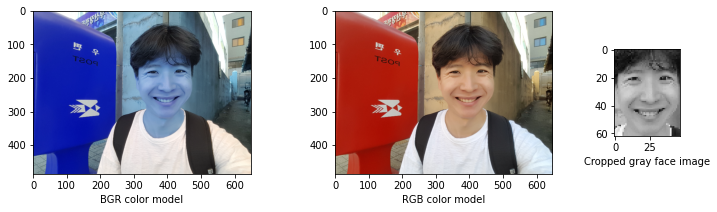

In [252]:
b, g, r = cv2.split(faces['images'][0]) # cv2.split을 사용하여 3채널 bgr 이미지를 1채널로 바꿈
rgb_img = cv2.merge([r,g,b]) # cv2.merge(list)를 사용하여 1채널 이미지를 3채널로 다시 변경 (여기서는 rgb로 변환)
fig, ax = plt.subplots(1, 3, figsize=(12, 3), gridspec_kw={'width_ratios': [4, 4, 1]})
ax[0].imshow(faces['images'][0])
ax[0].set_xlabel('BGR color model')
ax[1].imshow(rgb_img)
ax[1].set_xlabel('RGB color model')
ax[2].imshow(faces['face'][0], cmap='binary_r')
ax[2].set_xlabel('Cropped gray face image');

`faces` 데이터에서 training과 validataion 데이터 개수를 구한다.

In [253]:
n_training = np.sum(np.array(faces['mode']) == 'training')
n_validation = np.sum(np.array(faces['mode']) == 'validation')
n_emotion = len(emotion)
nt_per_emotion = n_training // n_emotion
nv_per_emotion = n_validation // n_emotion
n_training, n_validation, n_emotion, nt_per_emotion, nv_per_emotion

(400, 100, 5, 80, 20)

이 데이터 세트에 결쳐 있는 주요 축을 살펴보자. 이것은 대규모 데이터 세트이기 때문에 RandomizedPCA를 사용할 것이다. 여기에서 표준 PCA 추정기보다 훨씬 빠르게 첫번째 $N$ 주성분을 근사하는 무작위 방법이 포함되어 있으므로 고차원 데이터 (여기서는 차원이 거의 3,000)에 매우 유용하다. 이중 데이터의 크기와 데이터 차원 중 작은 값의 구성 요소를 갖는 pca (주성분 분석)을 수행한다. 이때 `sklearn.decomposition` 패키지의 `PCA` 모듈을 사용한다.

In [254]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized')
pca.fit(faces['data'][:n_training]) # training data만으로 pca를 실행함

PCA(svd_solver='randomized')

이 경우 처음 몇 개의 주요 성분과 관련된 이미지를 시각화하는 것이 흥미로울 수 있다. 이들 성분은 기술적으로 "eigenvectors"로 알려져 있으므로, 이러한 이미지를 "eigenfaces"라고 불린다. 이 그림에서 볼 수 있듯이 얼굴이 조금은 소름끼치는 모습이다.

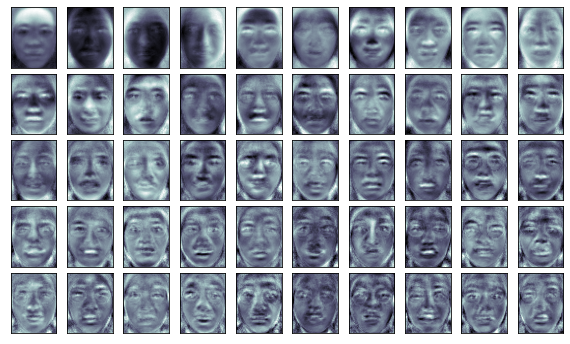

In [255]:
fig, axes = plt.subplots(5, 10, figsize=(10, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

이 결과는 매우 흥미롭고 이미지가 어떻게 변하는지에 대한 통찰력을 제공한다. 예를 들어, 처음 몇 개의 eigenfaces(왼쪽 상단부터)은 얼굴의 조명 각도와 연관되어 있고, 이후의 주요 벡터는 눈, 코, 입술과 같은 특정 feature가 선택되는 것처럼 보인다. 해당 벡터로의 투영이 얼마나 많은 데이터 정보를 보존하는지 보기 위해 이러한 성분의 분산을 그래프로 나타내면 다음과 같다.



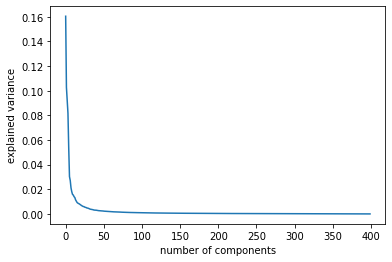

In [256]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance');

위의 각 성분을 순차적으로 누적하여 그래프로 나타내면 다음 그래프와 같이 구할 수 있다.

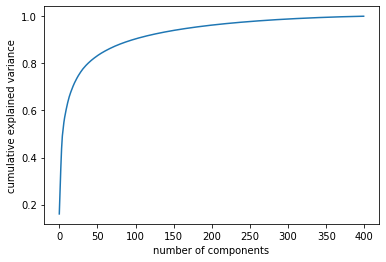

In [257]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

위의 누적 분산 그래프에서 세로축은 해당 성분을 누적하였을 때 원 영상의 정보를 얼마나 잘 설명할 수 있는지를 나타낸다. 이때 특정 설명가능한 분산 비율값 아래의 성분 수를 구함으로써 특정 설명가능한 분산 비율을 얻기 위해서 얼마나 많은 성분을 누적해야 하는지를 구할 수 있다. 이를 함수로 나타내면 `numberOfComponents(cumulatative_explained_variance)`이다.

In [258]:
# 아래 코드의 ... 부분을 완성한다.
def numberOfComponents(cev):
    return np.argmax(np.cumsum(pca.explained_variance_ratio_) >= cev)

In [259]:
# cumulative explained variance가 각각 0.5부터 0.9일 경우
# 필요한 number of components를 구함
nComp = [numberOfComponents((5+i)*0.1) for i in range(5)]
nComp

[5, 9, 18, 38, 96]

이 `nComp[4]`개의 성분은 분산의 90% 이상을 설명한다는 것을 알 수 있다. 이 `nComp[4]`개의 성분을 사용하면 데이터의 필수적인 특성을 대부분 복구할 수 있다는 것이다. 이를 보다 구체화하기 위하여 입력 이미지와 이들 50%, 60%, 70%, 80%, 90% 복구하기 위해 필요한 성분의 개수를 구하고 이들 성분으로부터 복구한 영상과 비교할 수 있다. 

In [260]:
# Compute the components and projected faces
projected = []
for i in range(len(nComp)):
    pca = PCA(nComp[i], svd_solver='randomized').fit(faces['data'])
    components = pca.transform(faces['data'])
    projected.append(pca.inverse_transform(components))

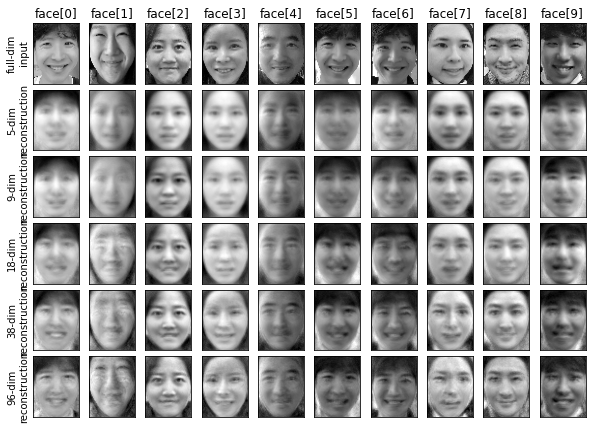

In [261]:
# Plot the results
fig, ax = plt.subplots(len(nComp)+1, 10, figsize=(10, 7.25),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces['data'][i].reshape(62, 47), cmap='binary_r')
    ax[0, i].set_title('face[%d]'%i)
    for j in range(5):
        ax[1+j, i].imshow(projected[j][i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
for j in range(5):
    ax[1+j, 0].set_ylabel('%d-dim\nreconstruction'%(nComp[j]));

여기의 위 행은 첫번째 10개의 입력 이미지를 보여주고, 아래 행들은 각각 ~3,000개의 초기 features 중 단 `n[]`개만을 사용하여 복구한 이미지를 보여준다. 이 시각화는 90% 정도의 원 영상을 복구하기 위해 전체 성분을 모두 필요로 하지 않는다는 것을 명확하게 보여준다. 데이터의 차원을 거의 20분의 1로 줄이지만 투영된 이미지에는 우리가 육안으로 볼 수 있는 충분한 정보가 포함되어 있다. 이미지로부터 개인을 인식하고 표정을 인식할 수 있는 정도이다. 이것이 의미하는 바는 우리가 선택하는 특정 알고리즘에 따라 의존적이긴 하지만, 우리의 분류 알고리즘이 3,000차원 데이터가 아닌 90%에 해당하는 성분수 만큼의 낮은 차원의 데이터에 대해 학습해도 된다는 것을 의미한다.

각 얼굴 표정별 랜덤으로 선택한 두개씩을 관찰해보자.

In [262]:
rand_idx = np.random.randint(0, nt_per_emotion-1)
rand_idx

43

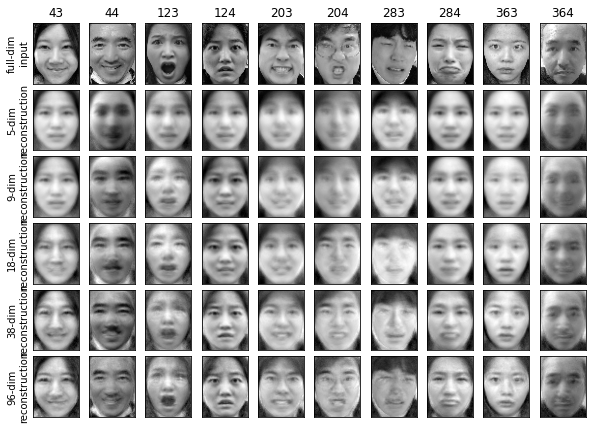

In [263]:
# Plot the results
fig, ax = plt.subplots(6, 10, figsize=(10, 7.25),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for fe in range(n_emotion):
    for k in range(2):
        i = fe*2 + k
        idx = fe*nt_per_emotion + rand_idx + k
        ax[0, i].imshow(faces['data'][idx].reshape(62, 47), cmap='binary_r')
        ax[0, i].set_title('%d' % idx)
        for j in range(5):
            ax[1+j, i].imshow(projected[j][idx].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
for j in range(5):
    ax[1+j, 0].set_ylabel('%d-dim\nreconstruction'%(nComp[j]));

각 표정별로 독립적인 pca를 만들고 원 영상을 80%의 복원 가능한 성분개수로 복원하였을 때의 결과를 살펴보도록 하자. 

In [264]:
# Compute the pca for each expression
# with 80% cumulative explainable variances
nComp80 = numberOfComponents(0.8)
pca_fe = []
projected_fe = []
for fe in range(len(emotion)):
    training_idx = fe*nt_per_emotion
    pca_fe.append(PCA(nComp80, svd_solver='randomized').fit(faces['data'][training_idx:training_idx+nt_per_emotion]))
    components = pca_fe[-1].transform(faces['data'][training_idx:training_idx+nt_per_emotion])
    projected_fe.append(pca_fe[-1].inverse_transform(components))

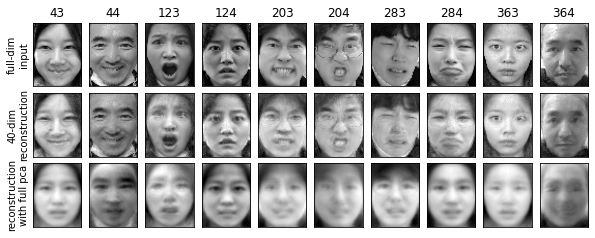

In [265]:
# Plot the results
fig, ax = plt.subplots(3, 10, figsize=(10, 3.75),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for fe in range(n_emotion):
    for k in range(2):
        i = fe*2 + k
        idx = fe*nt_per_emotion + rand_idx + k
        ax[0, i].imshow(faces['data'][idx].reshape(62, 47), cmap='binary_r')
        ax[0, i].set_title('%d' % idx)
        ax[1, i].imshow(projected_fe[fe][rand_idx + k].reshape(62, 47), cmap='binary_r')
        ax[2, i].imshow(projected[1][idx].reshape(62, 47), cmap='binary_r')
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('%d-dim\nreconstruction' % nComp80)
ax[2, 0].set_ylabel('reconstruction\nwith full pca');

위의 결과에서보면 각 표정별 pca를 실행한 후 80%에 해당하는 성분개수로 복원하였을 때 (두번째 행) 모든 표정 데이터로 생성한 하나의 pca 결과 (세번째 행)보다 더 원본 영상을 잘 복원하는 것을 확인할 수 있다.
이러한 특징을 이용하여 Validation 영상의 표정을 모른다는 가정하에 표정별 pca를 사용하여 복원하였을 때 원본 영상과 유사한지를 살펴보도록 하자.

In [266]:
rand_idxv = np.random.randint(0, nv_per_emotion-1)
rand_idxv

11

`projected_p[k]`는 모든 validation data를 k번째 표정의 pca를 사용하여 변환한 후 얻은 주성분을 다시 역변환하여 영상으로 복원한 결과를 저장한다.

In [267]:
projected_p = []
for fe in range(n_emotion):
    valid_idx = n_training
    components = pca_fe[fe].transform(faces['data'][valid_idx:valid_idx+n_validation])
    projected_p.append(pca_fe[fe].inverse_transform(components))

아래 코드에서 원 영상과 복구한 영상 간의 유사성을 검사하기 위하여 두 벡터 사이의 내적을 구하는 numpy.dot 함수를 이용하고, 각 벡터의 크기로 나누어줌으로써 영상의 상대적인 밝기에 따는 영향을 제거하였다. 이 값이 1.0에 가까울 수록 두 영상은 유사하다는 것을 의미한다.

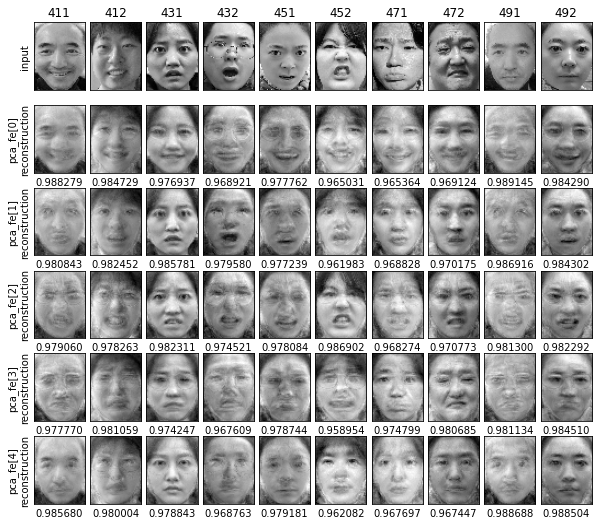

In [268]:
# Plot the results
fig, ax = plt.subplots(6, 10, figsize=(10, 9),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for fe in range(n_emotion):
    for k in range(2):
        i = fe*2 + k
        idx = n_training + fe*nv_per_emotion + rand_idxv + k
        face = faces['data'][idx]
        norm = np.linalg.norm(face)
        ax[0, i].imshow(face.reshape(62, 47), cmap='binary_r')
        ax[0, i].set_title('%d' % idx)        
        for j in range(5):
            projected = projected_p[j][idx-n_training]
            ax[1+j, i].imshow(projected.reshape(62, 47), cmap='binary_r')
            dots = np.dot(face, projected) / (norm * np.linalg.norm(projected))
            ax[1+j, i].set_xlabel('%1.6f' % dots)
    
ax[0, 0].set_ylabel('input')
for j in range(5):
    ax[1+j, 0].set_ylabel('pca_fe[%d]\nreconstruction' % j);

위 결과에서 보듯이 각 표정 그룹에서부터 랜덤 선택한 두장의 얼굴 영상에 대해 각 표정별 pca로 주성분을 추출한 후 다시 복원하였을 때 그 유사성은 해당 표정의 pca의 결과로 얻은 복원영상에서 가장 큰 값을 세번째 열의 영상은 `pca_fe[1]`으로 복원한 영상과 가장 유사하다는 것을 확인할 수 있다. 다만, 네번째 열의 원영상은 웃는 얼굴과 매우 유사하여 `pca_fe[0]`과 더 유사하다는 잘못된 결과를 도출하였다. (여러분의 실행결과는 랜덤 선택한 영상에 따라 다른 결과가 나올 수 있다.) 

이제 각 표정별 pca를 이용하여 분류기를 만들수 있다. 입력 얼굴영상에 대하여 각 표정별 pca를 이용하여 80%에 해당하는 성분을 추출하고, 이를 역변환하여 복원하였을 때 입력 영상과 얼마나 차이가 나는지를 구하고, 가장 차이가 적게 나는 pca에 해당하는 표정으로 분류하는 것이다. 아래의 `fe_classifier()` 함수는 face를 입력으로 하고 그 결과로 `emotion[]` 의 인덱스를 반환한다.

In [269]:
# 아래의 함수를 완성한다.
def fe_classifier(face):
    score = []
    for fe in range(n_emotion):
        compo = pca_fe[fe].transform(face.reshape(1,-1))
        projecting = pca_fe[fe].inverse_transform(compo)
        norm, pronorm = (np.linalg.norm(face), np.linalg.norm(projecting))
        dots = np.dot(projecting, face) / (norm * pronorm)
        score.append(dots)
    return np.argmax(np.array(score))

모든 Validation 영상에 대하여 `fe_classifier`의 결과와 비교해보자.

In [270]:
targets = [] # 분류기로 부터 얻은 결과
labels = [] # 정답
for fe in range(n_emotion):
    for i in range(nv_per_emotion):
        idx = n_training + fe*nv_per_emotion + i
        targets.append(fe_classifier(faces['data'][idx]))
        labels.append(fe)

모든 데이터에 대하여 정답과 분류기 결과를 비교하는 방법으로 아래의 confusion matrix를 활용하면 효과적이다. 얼마나 많은 데이터들이 predicted label과 true label의 모든 조합에 해당되는지 그 수를 나타대고 있기 때문에 쉽게 오분류의 경향을 분석할 수 있다. 

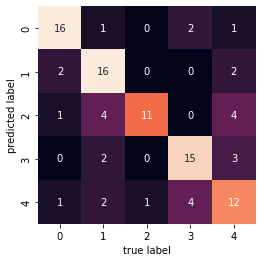

In [272]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(targets, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=range(n_emotion),
            yticklabels=range(n_emotion))
plt.xlabel('true label')
plt.ylabel('predicted label');

아래의 코드를 통해 정확도를 계산한다.

In [275]:
from sklearn.metrics import accuracy_score
accuracy_score(targets, labels)

0.7